# Tensor Network Renormalization Group for the 2D Ising model

In [1]:
using LinearAlgebra

In [2]:
using Plots

┌ Info: Recompiling stale cache file /home/ssteinha/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1187


Define the basic functions for the Ising model

Define Kronecker Delta

In [3]:
function kronecker_delta(i::Int,j::Int)
    
    res = 0.
    
    if i==j
        
        res = 1.
        
    end
    
    res
    
end

kronecker_delta (generic function with 1 method)

In [4]:
kronecker_delta(1,1)

1.0

In [5]:
kronecker_delta(1,2)

0.0

Define the weight functions of Ising model

$Z_2$ has two representations, $k=0$ and $k=1$. The weight on an edge is $\cosh(\beta)$ for $k=0$, $\sinh(\beta)$ for $k=1$.

In [6]:
function weight(beta::Float64,k::Int)
    
    res = 1/2 * (exp(beta) + (-1)^k * exp(-beta))
    
    res
    
end

weight (generic function with 1 method)

In [7]:
weight(1.5,0)

2.352409615243247

Define the initial tensor

The tensor is 4-valent, each edge carrying a representation of $Z_2$, and a square root of an edge weight (for $\beta$ and $k$). On the vertex, we have a Kronecker Delta of the sum of the 4 representations meeting at the vertex modulo 2; if this sum is 1, it vanishes.

Note that Julia starts counting array indices with 1, not 0. You need to account for that.

In [8]:
function init_tensor(beta::Float64)
    
    tensor = zeros(2,2,2,2)
    
    for i in 1:2, j in 1:2, k in 1:2, l in 1:2
        
        tensor[i,j,k,l] = sqrt(weight(beta,i-1) * weight(beta,j-1) * weight(beta,k-1) * weight(beta,l-1)) *
            kronecker_delta(mod(i+j+l+k,2),0)
        
    end
    
    return tensor
    
end

init_tensor (generic function with 1 method)

In [9]:
tensor = init_tensor(1.0)

2×2×2×2 Array{Float64,4}:
[:, :, 1, 1] =
 2.3811  0.0    
 0.0     1.81343

[:, :, 2, 1] =
 0.0      1.81343
 1.81343  0.0    

[:, :, 1, 2] =
 0.0      1.81343
 1.81343  0.0    

[:, :, 2, 2] =
 1.81343  0.0   
 0.0      1.3811

In [10]:
length(tensor[:,1,1,1])

2

Splitting tensors for the singular value decomposition

This will be similar to the introductory Julia File. We pair the indices of the tensor in the way we want to split it, and define a matrix. On this matrix we will apply a singular value decomposition, truncate here at 2 singular values, and define new 3-valent tensors from it.

Translating back just means splitting the combined index again into two separate ones.

The function should return two 3-valent tensors and a list of singular values.

Normalize the singular values with respect to the largest one (so the largest singular value is always one).

In [11]:
function compute_SVD1(tensor::Array{Float64,4})
    
    #length of tensor
    
    len = length(tensor[:,1,1,1])
    
    mat = zeros(len^2,len^2)
    
    index1 = 0
    
    for i in 1:len, l in 1:len
        
        index1 += 1
        
        index2 = 0
        
        for j in 1:len, k in 1:len
            
            index2 += 1
            
            mat[index1,index2] = tensor[i,j,k,l]
            
        end
        
    end
    
    #Compute the SVD
    
    println("Compute SVD")
    
    decomp = svd(mat)
    
    U = decomp.U
    S = decomp.S
    V = decomp.V' # Gives us V^\dagger
    
    println("Print SVs")
    
    println(S / S[1]) #prints normalized singular values
    
    #Define the new S1 and S2
    
    S1 = zeros(len,len,len) # Here I make the choice to keep the same bond dimension
    S2 = zeros(len,len,len)
    
    index1 = 0
    
    for i in 1:len, l in 1:len
        
        index1 += 1
        
        for p in 1:len
        
            S1[i,l,p] = U[index1,p] * sqrt(S[p] / S[1])
            
        end
        
    end
    
    index2 = 0
        
    for j in 1:len, k in 1:len
            
        index2 += 1
            
            for q in 1:len
        
            S2[j,k,q] = sqrt(S[q] / S[1]) * V[q,index2]
            
        end
        
    end
    
    return (S1,S2,S / S[1])
    
end    

compute_SVD1 (generic function with 1 method)

In [12]:
(S1test,S2test) = compute_SVD1(tensor)

Compute SVD
Print SVs
[1.0, 0.964028, 4.69534e-17, 4.17334e-17]


([-0.795551 0.0; 0.0 -0.605887]

[0.0 -0.694272; -0.694272 0.0], [-0.795551 0.0; 0.0 -0.605887]

[-0.0 -0.694272; -0.694272 0.0], [1.0, 0.964028, 4.69534e-17, 4.17334e-17])

We need to the same again, but this time for the other splitting.

In [13]:
function compute_SVD2(tensor::Array{Float64,4})
    
    #length of tensor
    
    len = length(tensor[:,1,1,1])
    
    mat = zeros(len^2,len^2)
    
    index1 = 0
    
    for i in 1:len, j in 1:len
        
        index1 += 1
        
        index2 = 0
        
        for k in 1:len, l in 1:len
            
            index2 += 1
            
            mat[index1,index2] = tensor[i,j,k,l]
            
        end
        
    end
    
    #Compute the SVD
    
    println("Compute SVD")
    
    decomp = svd(mat)
    
    U = decomp.U
    S = decomp.S
    V = decomp.V' # Gives us V^\dagger
    
    println("Print SVs")
    
    println(S / S[1]) #prints normalized singular values
    
    #Define the new S1 and S2
    
    S3 = zeros(len,len,len) # Here I make the choice to keep the same bond dimension
    S4 = zeros(len,len,len)
    
    index1 = 0
    
    for i in 1:len, j in 1:len
        
        index1 += 1
        
        for p in 1:len
        
            S3[i,j,p] = U[index1,p] * sqrt(S[p] / S[1])
            
        end
        
    end
    
    index2 = 0
        
    for k in 1:len, l in 1:len
            
        index2 += 1
            
            for q in 1:len
        
            S4[k,l,q] = sqrt(S[q] / S[1]) * V[q,index2]
            
        end
        
    end
    
    return (S3,S4,S / S[1])
    
end    

compute_SVD2 (generic function with 1 method)

In [14]:
(S3test,S4test) = compute_SVD2(tensor)

Compute SVD
Print SVs
[1.0, 0.964028, 1.4086e-16, 0.0]


([-0.795551 0.0; 0.0 -0.605887]

[0.0 -0.694272; -0.694272 0.0], [-0.795551 0.0; 0.0 -0.605887]

[-0.0 -0.694272; -0.694272 0.0], [1.0, 0.964028, 1.4086e-16, 0.0])

In [15]:
S3test

2×2×2 Array{Float64,3}:
[:, :, 1] =
 -0.795551   0.0     
  0.0       -0.605887

[:, :, 2] =
  0.0       -0.694272
 -0.694272   0.0     

To get the new effective tensor, we now have to contract the fine degrees of freedom.

In [16]:
function contract(S1::Array{Float64,3},S2::Array{Float64,3},S3::Array{Float64,3},S4::Array{Float64,3})
    
    len_coarse = length(S1[1,1,:])
    
    len_fine = length(S1[:,1,1])
    
    new_ten = zeros(len_coarse,len_coarse,len_coarse,len_coarse)
    
    for p in 1:len_coarse, q in 1:len_coarse, r in 1:len_coarse, s in 1:len_coarse
        
        for i in 1:len_fine, j in 1:len_fine, k in 1:len_fine, l in 1:len_fine
            
            new_ten[p,q,r,s] += S1[i,j,p] * S2[l,k,r] * S3[k,j,q] * S4[i,l,s]
            
        end
        
    end
    
    return new_ten
    
end

contract (generic function with 1 method)

In [17]:
contract(S1test,S2test,S3test,S4test)

2×2×2×2 Array{Float64,4}:
[:, :, 1, 1] =
 0.535325  0.0     
 0.0       0.482014

[:, :, 2, 1] =
 0.0       0.482014
 0.464675  0.0     

[:, :, 1, 2] =
 0.0       0.464675
 0.482014  0.0     

[:, :, 2, 2] =
 0.482014  0.0     
 0.0       0.464675

To compute the flow of renormalized tensors, we have to iterate these procedures a few times. We write this into a main function.

We have to specify the number of iterations of the algorithm, then define the initial tensor. We can pass $\beta$ as a parameter of the main function.

Then we do a for loop, in which we do the first splitting, second splitting and then contract the new three valent tensor. Then we repeat.

For each iteration we should store the singular values computed in the singular value decomposition. We will afterwards plot them to distinguish the phases of the Ising model and finding the phase transition.

In [18]:
function main(beta::Float64)
    
    iter = 30 #number of iterations
    
    svlist = zeros(iter,4)
    
    tensor = init_tensor(beta)
    
    for i in 1:iter
        
        println("Iteration ", i)
        
        println("Compute first SVD")
        
        (S1,S2,sv1) = compute_SVD1(tensor);
        
        println("Compute second SVD")
        
        (S3,S4,sv2) = compute_SVD2(tensor);
        
        svlist[i,1] = i
        svlist[i,2] = sv1[2]
        svlist[i,3] = sv1[3]
        svlist[i,4] = sv1[4]
        
        println("Compute new tensor")
        
        tensor = contract(S1,S2,S3,S4)
        
        println()
        
    end
    
    return svlist
    
end

main (generic function with 1 method)

If it is running, try the algorithm for different initial values of $\beta$ and look for a phase transition. The actual critical inverse temperature of the 2D square lattice Ising model is $\beta_c \approx 0.4406...$. The plot the singular values for different betas.

In [19]:
res0_3 = main(0.3);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.0, 0.53705, 3.31113e-17, 2.24788e-17]
Compute second SVD
Compute SVD
Print SVs
[1.0, 0.53705, 6.62226e-17, 0.0]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[1.0, 0.436412, 0.131445, 0.0573641]
Compute second SVD
Compute SVD
Print SVs
[1.0, 0.436412, 0.131445, 0.0573641]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[1.0, 0.397664, 0.0986671, 0.0392363]
Compute second SVD
Compute SVD
Print SVs
[1.0, 0.397664, 0.0986671, 0.0392363]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[1.0, 0.329952, 0.105168, 0.0347005]
Compute second SVD
Compute SVD
Print SVs
[1.0, 0.329952, 0.105168, 0.0347005]
Compute new tensor

Iteration 5
Compute first SVD
Compute SVD
Print SVs
[1.0, 0.257491, 0.0974826, 0.0251009]
Compute second SVD
Compute SVD
Print SVs
[1.0, 0.257491, 0.0974826, 0.0251009]
Compute new tensor

Iteration 6
Compute first SVD
Compute SVD
Print SVs
[1.0, 0.1

In [20]:
res0_7 = main(0.7);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.0, 0.885352, 0.0, -0.0]
Compute second SVD
Compute SVD
Print SVs
[1.0, 0.885352, 0.0, -0.0]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[1.0, 0.873306, 0.0531058, 0.0463776]
Compute second SVD
Compute SVD
Print SVs
[1.0, 0.873306, 0.0531058, 0.0463776]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[1.0, 0.959152, 0.013882, 0.013315]
Compute second SVD
Compute SVD
Print SVs
[1.0, 0.959152, 0.013882, 0.013315]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[1.0, 0.984828, 0.00685986, 0.00675578]
Compute second SVD
Compute SVD
Print SVs
[1.0, 0.984828, 0.00685986, 0.00675578]
Compute new tensor

Iteration 5
Compute first SVD
Compute SVD
Print SVs
[1.0, 0.998294, 0.000782592, 0.000781257]
Compute second SVD
Compute SVD
Print SVs
[1.0, 0.998294, 0.000782592, 0.000781257]
Compute new tensor

Iteration 6
Compute first SVD
Compute SVD
Print SVs
[1.0, 0.999856, 7

Plot the singular values, actually the second largest one.

In [21]:
y = [res0_3[:,2],res0_7[:,2]]

2-element Array{Array{Float64,1},1}:
 [0.53705, 0.436412, 0.397664, 0.329952, 0.257491, 0.184526, 0.121123, 0.0732355, 0.0413942, 0.0222755  …  4.4238e-10, 6.3344e-11, 3.33452e-34, 2.23092e-45, 5.36869e-36, 1.17017e-161, 2.34903e-108, 1.34302e-173, 0.0, 0.0]
 [0.885352, 0.873306, 0.959152, 0.984828, 0.998294, 0.999856, 0.999998, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                                                                                  

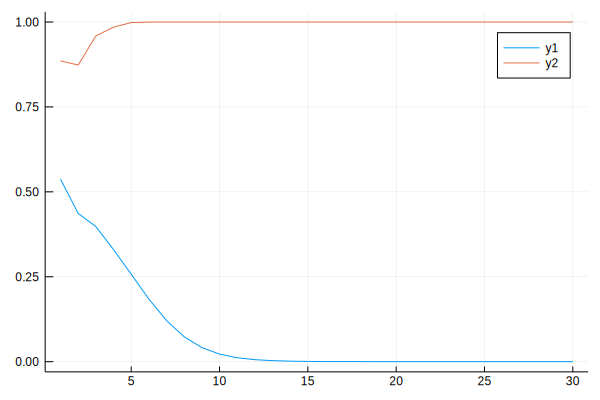

In [22]:
plot(res0_3[:,1],y)

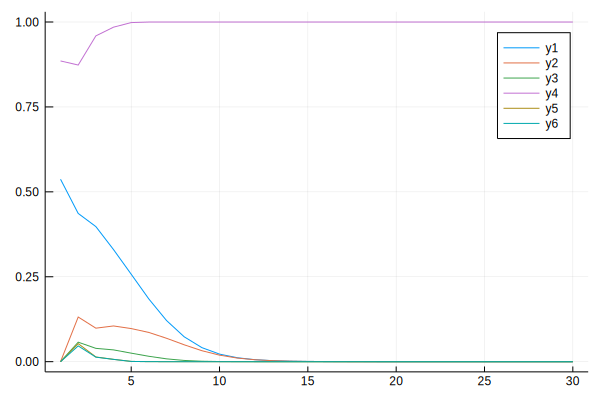

In [24]:
plot(res0_3[:,1],[res0_3[:,2],res0_3[:,3],res0_3[:,4],res0_7[:,2],res0_7[:,3],res0_7[:,4]])